# 1 - Data Extraction - COVID Jabs data

Here we will download all the data we need.

Because it is too large (about 150 GB), we'll also apply some pre-processing on the data.

In [1]:
# imports
import os
import json
import requests
import pandas as pd
from matplotlib import rcParams, rcParamsDefault, pyplot as plt
import seaborn as sns
from tqdm import tqdm

# matplotlib config
rcParams.update(rcParamsDefault)
rcParams['figure.figsize'] = (14, 10)
rcParams['figure.dpi'] = 100

# seaborn config
sns.set_theme()

In [2]:
# dotenv incantations
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

## 1.1. OpenDataSUS - Jab data

First, let's extract the jabs data. This is a dataset of each and every COVID jab applied in Brazil.

In [3]:
# get API connection info via .env file
COVIDJAB_API_URL = os.environ.get("COVIDJAB_API_URL")
COVIDJAB_API_URL_FIRST = os.environ.get("COVIDJAB_API_URL_FIRST")
COVIDJAB_API_USER = os.environ.get("COVIDJAB_API_USER")
COVIDJAB_API_PASSWD = os.environ.get("COVIDJAB_API_PASSWD")

api_auth = requests.auth.HTTPBasicAuth(
    COVIDJAB_API_USER,
    COVIDJAB_API_PASSWD
)

print(f'API URL: "{COVIDJAB_API_URL}"')
print(f'API URL (first page): "{COVIDJAB_API_URL_FIRST}"')
print(f'API username: "{COVIDJAB_API_USER}"')
print(f'API password: "{COVIDJAB_API_PASSWD}"')

API URL: "https://imunizacao-es.saude.gov.br/_search/scroll"
API URL (first page): "https://imunizacao-es.saude.gov.br/_search?scroll=1m"
API username: "imunizacao_public"
API password: "qlto5t&7r_@+#Tlstigi"


Let's define a preprocessing function for each page so I won't run out of memory trying to download all the data in one go.

The idea is, I download a few pages of results, then apply the `preprocess()` function on the raw dataframe to eliminate immaterial information, then concat the preprocessed DF with previous preprocessed DFs and store that in-memory. Rinse and repeat until done.

In [32]:
# function to classify vaccines into their function mechanisms
def mechanisms(name):
    name = name.lower()
    if 'comirnaty' in name:
        return 'mrna'
    elif 'coronavac' in name:
        return 'inactivated'
    elif 'novavax' in name:
        return 'subunit'
    elif 'covishield' in name or 'chad' in name or 'ad26' in name or 'sputnik' in name:
        return 'viral_vector'
    else:
        return 'unknown'

# preprocess
def preprocess_index(df):
    return df.set_index(['document_id', 'paciente_id'])

def preprocess_drop_invalid_rows(df):
    return df[
        (df['status']=='final')&
        (df['vacina_dataAplicacao']>='2020-01')
    ]

def preprocess_drop_cols(df):
    return df[
        [
            'estabelecimento_uf',
            'vacina_dataAplicacao',
            'vacina_nome',
        ]
    ]

def preprocess_dtype(df):
    df['vacina_dataAplicacao'] = pd.to_datetime(df['vacina_dataAplicacao'])
    df['estabelecimento_uf'] = df['estabelecimento_uf'].astype('category')
    df['vacina_nome'] = df['vacina_nome'].astype('category')

    return df

def preprocess_add_mechanisms(df):
    df['mechanism'] = df['vacina_nome'].apply(mechanisms)
    df['mechanism'] = df['mechanism'].astype('category')
    return df

def preprocess(df):
    df_raw = df.copy()

    df = (df_raw
        .pipe(preprocess_index)
        .pipe(preprocess_drop_invalid_rows)
        .pipe(preprocess_drop_cols)
        .pipe(preprocess_dtype)
        .pipe(preprocess_add_mechanisms)
    )

    return df

Let's now download the data from OpenDataSUS. This might take a few hours:

In [33]:
HITS_PER_PAGE = 10000
full_dfs = None
pre_df = None

# first page POST params
payload = {
    'size': HITS_PER_PAGE
}

# extract first page
html = requests.post(COVIDJAB_API_URL_FIRST, 
    auth = api_auth,
    json = payload,
)
response_json = html.json()

hits = response_json['hits']['hits']
total_hits = response_json['hits']['total']['value']
total_pages = total_hits // HITS_PER_PAGE
page_count = 0

while hits:
    # get scroll id for making next page request
    scroll_id = response_json['_scroll_id']

    # getting the data into a dataframe
    dataframe_dict = [ hit['_source'] for hit in hits ]
    single_df = pd.DataFrame(dataframe_dict)

    # accumulate into a single dataframe
    if full_dfs is None: # there is no data in the accumulator. Either this is the first page of results,
                         # or the accumulator has just been emptied by the preprocessing code just ahead
        full_dfs = single_df.copy()
    else: 
        full_dfs = pd.concat([full_dfs, single_df])

    # extract subsequent pages
    payload = {
        'scroll_id': scroll_id,
        'scroll': '1m'
    }
    
    html = requests.post(COVIDJAB_API_URL, 
        auth = api_auth,
        json = payload,
    )
    response_json = html.json()
    hits = response_json['hits']['hits']
    
    # progress display. Every ten pages, we display a message and run the preprocessing routine to
    # make the memory requirements more manageable. It might still run into the tens of GBs range.
    page_count += 1
    print('.', end = '')
    if not page_count % 5:
        print(f' page count: {page_count} of {total_pages} ({page_count/total_pages:.1%} done)')

        pre_df_single = preprocess(full_dfs)
        if pre_df is None:
            pre_df = pre_df_single.copy()
        else:
            pre_df = pd.concat([pre_df, pre_df_single])
        
        # empty the raw data accumulator
        full_dfs = None

# run the preprocessing again on the remaining raw data
if full_dfs is not None:
    pre_df_single = preprocess(full_dfs)
    if pre_df is None:
        pre_df = pre_df_single.copy()
    else:
        pre_df = pd.concat([pre_df, pre_df_single])
    
    # empty the raw data accumulator
    full_dfs = None

..... page count: 5 of 54027 (0.0% done)
..... page count: 10 of 54027 (0.0% done)
..... page count: 15 of 54027 (0.0% done)
..... page count: 20 of 54027 (0.0% done)
..... page count: 25 of 54027 (0.0% done)
..... page count: 30 of 54027 (0.1% done)
..... page count: 35 of 54027 (0.1% done)
..... page count: 40 of 54027 (0.1% done)
..... page count: 45 of 54027 (0.1% done)
..... page count: 50 of 54027 (0.1% done)
..... page count: 55 of 54027 (0.1% done)
..... page count: 60 of 54027 (0.1% done)
..... page count: 65 of 54027 (0.1% done)
..... page count: 70 of 54027 (0.1% done)
..... page count: 75 of 54027 (0.1% done)
..... page count: 80 of 54027 (0.1% done)
..... page count: 85 of 54027 (0.2% done)
..... page count: 90 of 54027 (0.2% done)
..... page count: 95 of 54027 (0.2% done)
..... page count: 100 of 54027 (0.2% done)
..... page count: 105 of 54027 (0.2% done)
..... page count: 110 of 54027 (0.2% done)
..... page count: 115 of 54027 (0.2% done)
..... page count: 120 of 54027 

KeyError: 'hits'

In [34]:
full_dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 42 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   estalecimento_noFantasia                  10000 non-null  object 
 1   vacina_lote                               10000 non-null  object 
 2   estabelecimento_municipio_codigo          10000 non-null  object 
 3   estabelecimento_valor                     10000 non-null  object 
 4   vacina_nome                               10000 non-null  object 
 5   ds_condicao_maternal                      2419 non-null   object 
 6   paciente_endereco_coPais                  9995 non-null   object 
 7   @version                                  10000 non-null  object 
 8   document_id                               10000 non-null  object 
 9   paciente_nacionalidade_enumNacionalidade  9994 non-null   object 
 10  vacina_categoria_codigo            

In [11]:
#full_dfs['status'].value_counts(normalize = True)

final               0.9244
entered-in-error    0.0756
Name: status, dtype: float64

In [12]:
#pre_df = preprocess(full_dfs[full_dfs['paciente_idade']>=18])

In [35]:
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1151011 entries, ('c8a56fe7-40de-4b95-9e90-8bbb55c0af36-i0b0', '6e71d65a8cd610769edcab180d159a51adb5d96f9898e7da9449999fae2b3912') to ('1ae43454-b743-45f8-ba14-11e049e1a8ec-i0b0', 'e91753034be5d6f6f423cd69f419bc0f0877f2836b262ef4ea5f3a8065a3333a')
Data columns (total 4 columns):
 #   Column                Non-Null Count    Dtype              
---  ------                --------------    -----              
 0   estabelecimento_uf    1151011 non-null  object             
 1   vacina_dataAplicacao  1151011 non-null  datetime64[ns, UTC]
 2   vacina_nome           1151011 non-null  object             
 3   mechanism             1151011 non-null  category           
dtypes: category(1), datetime64[ns, UTC](1), object(2)
memory usage: 118.3+ MB


In [36]:
# saving for future use
pre_df.to_parquet('brazil_covidjabs_state_monthly.parquet')

In [23]:
pre_df['mechanism'].value_counts(normalize = False, dropna = False)

mrna            347046
viral_vector    267363
inactivated     111222
Name: mechanism, dtype: int64

In [39]:
gb_uf_month_type = pre_df.groupby([
    pd.Grouper(key = 'vacina_dataAplicacao', freq = 'M'), 
    'estabelecimento_uf', 
    'vacina_nome'
], dropna = False)

jabs_by_uf_month_type = gb_uf_month_type[['vacina_nome']].count()

jabs_by_uf_month_type.rename(columns  = {'vacina_nome': 'total_jabs'}, inplace = True)
jabs_by_uf_month_type.reset_index(inplace = True)

jabs_by_uf_month_type['mechanism'] = jabs_by_uf_month_type['vacina_nome'].apply(mechanisms)

In [41]:
jabs_by_uf_month_type[jabs_by_uf_month_type['total_jabs']>0]

,vacina_dataAplicacao,estabelecimento_uf,vacina_nome,total_jabs,mechanism
0,2020-01-31 00:00:00+00:00,RJ,COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD,1,viral_vector
1,2020-02-29 00:00:00+00:00,PR,COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD,1,viral_vector
2,2020-02-29 00:00:00+00:00,RN,COVID-19 PFIZER - COMIRNATY,1,mrna
3,2020-03-31 00:00:00+00:00,ES,COVID-19 SINOVAC/BUTANTAN - CORONAVAC,1,inactivated
4,2020-04-30 00:00:00+00:00,AM,COVID-19 SINOVAC/BUTANTAN - CORONAVAC,1,inactivated
...,...,...,...,...,...
3418,2023-02-28 00:00:00+00:00,SP,COVID-19 SINOVAC/BUTANTAN - CORONAVAC,1092,inactivated
3419,2023-02-28 00:00:00+00:00,TO,COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD,11,viral_vector
3420,2023-02-28 00:00:00+00:00,TO,COVID-19 PFIZER - COMIRNATY,57,mrna
3421,2023-02-28 00:00:00+00:00,TO,COVID-19 PFIZER - COMIRNATY PEDIÁTRICA,3,mrna


In [42]:
jabs_by_uf_month_type['mechanism'].value_counts(normalize = False, dropna = False)

mrna            1321
viral_vector    1217
inactivated      885
Name: mechanism, dtype: int64

In [43]:
def mrna_only(df):
    sum_mrna = df.loc[df['mechanism']=='mrna', 'total_jabs'].sum()
    return sum_mrna

gb = jabs_by_uf_month_type.groupby(
    by = ['vacina_dataAplicacao', 'estabelecimento_uf']
)
jabs_by_uf_month_mrna = gb[['total_jabs']].sum()
jabs_by_uf_month_mrna['mrna_jabs'] = gb.apply(mrna_only)

jabs_by_uf_month_mrna['total_jabs_cum'] = jabs_by_uf_month_mrna['total_jabs'].cumsum()
jabs_by_uf_month_mrna['mrna_jabs_cum'] = jabs_by_uf_month_mrna['mrna_jabs'].cumsum()

jabs_by_uf_month_mrna.reset_index(inplace = True)

In [44]:
jabs_by_uf_month_mrna[jabs_by_uf_month_mrna['total_jabs'] > 0]

,vacina_dataAplicacao,estabelecimento_uf,total_jabs,mrna_jabs,total_jabs_cum,mrna_jabs_cum
0,2020-01-31 00:00:00+00:00,RJ,1,0,1,0
1,2020-02-29 00:00:00+00:00,PR,1,0,2,0
2,2020-02-29 00:00:00+00:00,RN,1,1,3,1
3,2020-03-31 00:00:00+00:00,ES,1,0,4,1
4,2020-04-30 00:00:00+00:00,AM,1,0,5,1
...,...,...,...,...,...,...
716,2023-02-28 00:00:00+00:00,RS,546,491,1145036,500318
717,2023-02-28 00:00:00+00:00,SC,295,200,1145331,500518
718,2023-02-28 00:00:00+00:00,SE,179,129,1145510,500647
719,2023-02-28 00:00:00+00:00,SP,5425,4305,1150935,504952


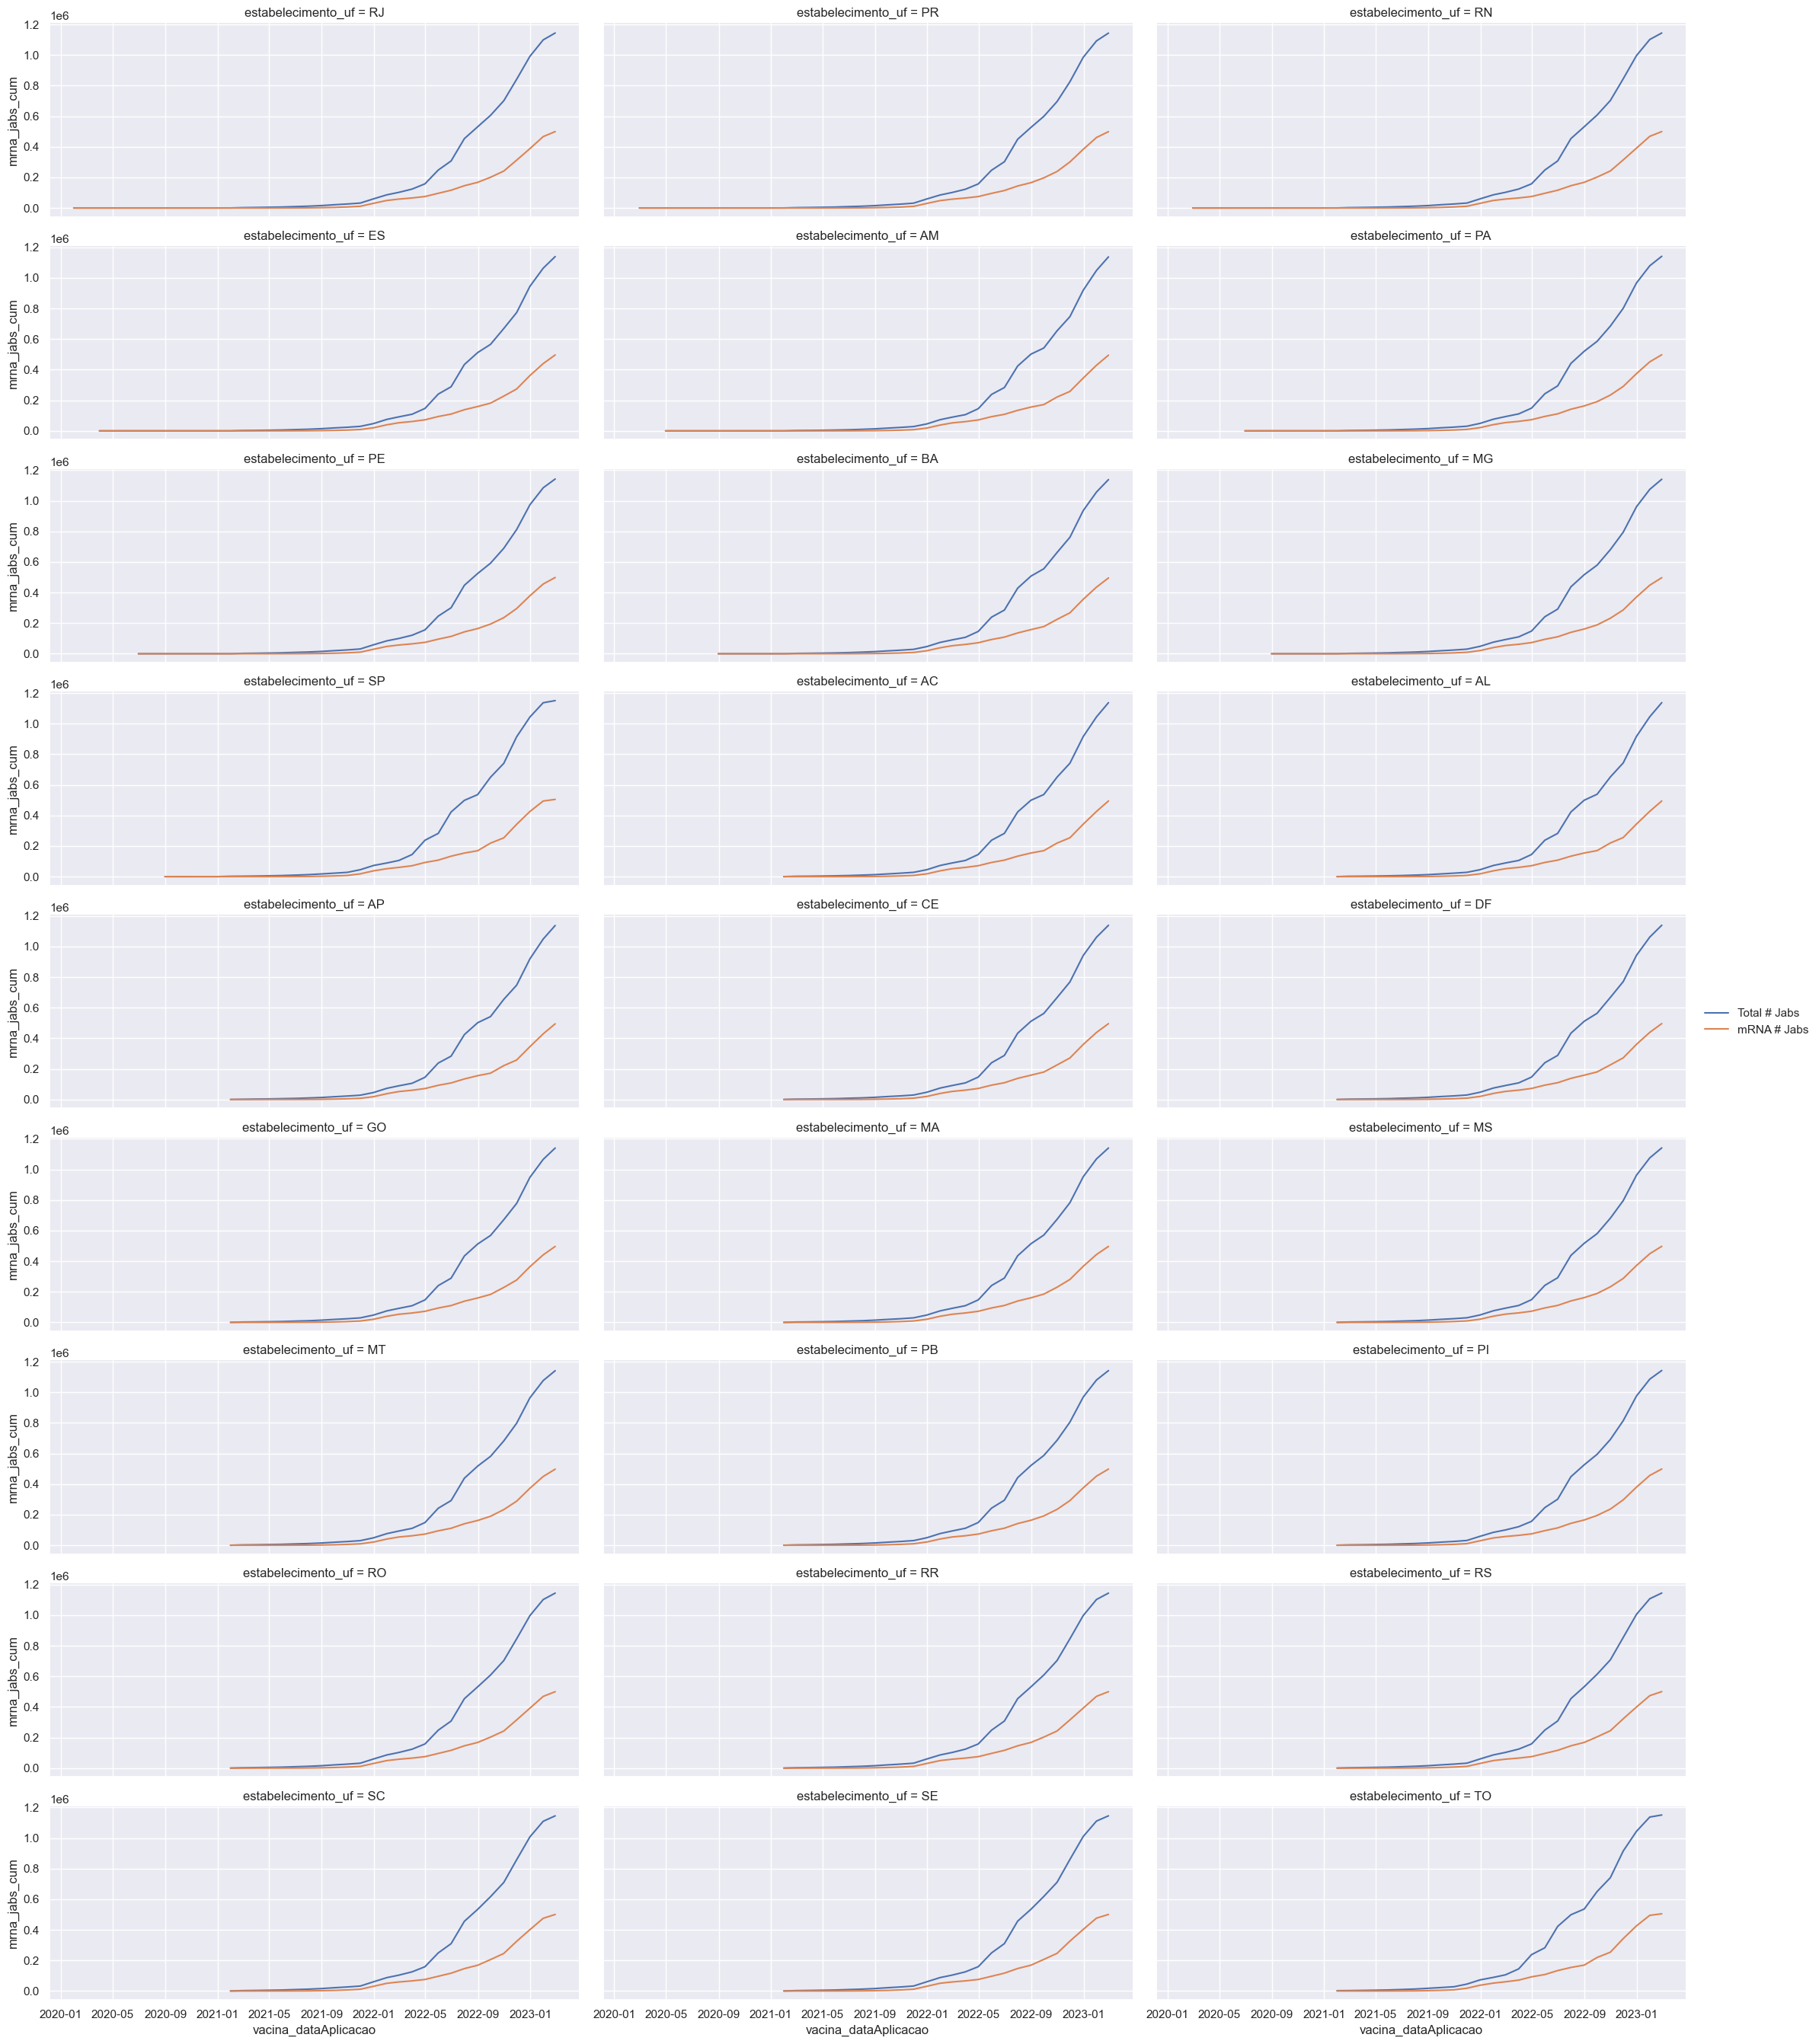

In [54]:
facetgrid = sns.FacetGrid(
    data = jabs_by_uf_month_mrna, 
    col = 'estabelecimento_uf', 
    col_wrap = 3, aspect = 2.5
)

facetgrid.map_dataframe(sns.lineplot, 
    x = 'vacina_dataAplicacao', y = 'total_jabs_cum',
    label = 'Total # Jabs'
)

facetgrid.map_dataframe(sns.lineplot, 
    x = 'vacina_dataAplicacao', y = 'mrna_jabs_cum',
    color = sns.color_palette()[1],
    label = 'mRNA # Jabs'
)

facetgrid.add_legend()